<a href="https://colab.research.google.com/github/emiresenov/MTT040-PD-ConvNN/blob/main/PD_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you’ll do in this notebook

In this mini-project you’ll build an image classifier using a Convolutional Neural Network (CNN) in TensorFlow/Keras to recognize different partial discharge (PD) patterns from images (e.g., internal, corona, surface/superficial). You do not need to be a programming expert, just run each cell in order and read the explanations.



## Note

If you are in Google Colab, switch the runtime to GPU (Runtime → Change runtime type) and switch to a GPU or TPU to make training much faster. Running this code with a CPU will be very slow.

## Environment setup (imports, GPU check, and seeds)

This cell imports the libraries we’ll use, prints your TensorFlow version, and confirms whether a GPU is available. We then set random seeds so that your train/val/test splits and model training are reproducible (you should get the same results each time you run).

In [1]:
# If you're in Colab, enable a GPU via: Runtime > Change runtime type > GPU
import os, sys, zipfile, pathlib, random
from pathlib import Path

import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow: 2.19.0
GPU available: True


## Download and extract the dataset

This cell downloads a ZIP file containing the PD images directly from Mendeley Data to the /content directory (as used by Colab), then unzips it into pd_raw/. Finally, it prints a few paths so you can see the folder structure and confirm the data is in place.

In [2]:
# Direct "Download all" ZIP from Mendeley Data (Version 7)
ZIP_URL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xz4xhrc4yr-7.zip"

DATA_DIR = Path("/content")
ZIP_PATH = DATA_DIR / "pd.zip"
RAW_DIR = DATA_DIR / "pd_raw"

# Fetch zip
!wget -q -O "$ZIP_PATH" "$ZIP_URL"

# Extract
RAW_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(RAW_DIR)

# Peek at extracted structure
for p in list(RAW_DIR.glob("*"))[:10]:
    print(p)


/content/pd_raw/Images of resolved phase patterns of partial discharges in electric generators


## Gather image paths and assign labels

Here we:

- Define which file extensions count as images.
- Create a small label dictionary that maps folder names (e.g., superficial) to a canonical label (e.g., surface) so class names are consistent.
- Walk the extracted folders, pick up all image files, and infer their label from the folder names.
- Print the number of images, the set of labels, and a per-class count.
- Sanity-check that we found at least two classes (so classification makes sense).

In [3]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

LABEL_CANON = {
    "internal": "internal",
    "corona": "corona",
    "surface": "surface",
    "superficial": "surface",  # unify naming
}

def find_label_from_path(path: Path):
    for part in reversed(path.parts):
        key = part.lower()
        if key in LABEL_CANON:
            return LABEL_CANON[key]
    # also allow labels appearing as substrings in folder names
    lower = [p.lower() for p in path.parts]
    for key in LABEL_CANON:
        if any(key in seg for seg in lower):
            return LABEL_CANON[key]
    return None

# Gather all images
all_imgs = []
for p in RAW_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        lbl = find_label_from_path(p.parent)
        if lbl is not None:
            all_imgs.append((str(p), lbl))

print(f"Found {len(all_imgs)} labeled images.")
labels = sorted(set(lbl for _, lbl in all_imgs))
print("Labels:", labels)

# Basic sanity: ensure we have (at least) two classes
from collections import Counter
cnt = Counter(lbl for _, lbl in all_imgs)
print("Per-class counts:", cnt)

assert len(labels) >= 2, "Did not detect at least two classes. Check extracted folders."


Found 945 labeled images.
Labels: ['corona', 'internal', 'surface']
Per-class counts: Counter({'internal': 321, 'surface': 316, 'corona': 308})


## Make train/validation/test splits (stratified)

We convert text labels to numeric IDs (e.g., {"corona": 0, "internal": 1, ...}) and split the data into:

- Train (for learning),
- Validation (for tuning and early stopping),
- Test (for the final, unbiased evaluation).

We use stratified splits so each subset keeps roughly the same class proportions as the full dataset.

In [4]:
from sklearn.model_selection import train_test_split

paths = np.array([p for p, _ in all_imgs])
y_text = np.array([lbl for _, lbl in all_imgs])

label_to_id = {lbl:i for i, lbl in enumerate(sorted(set(y_text)))}
id_to_label = {i:lbl for lbl, i in label_to_id.items()}
y = np.array([label_to_id[lbl] for lbl in y_text])

X_train, X_tmp, y_train, y_tmp = train_test_split(
    paths, y, test_size=0.2, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Classes:", id_to_label)


Train: 756, Val: 94, Test: 95
Classes: {0: np.str_('corona'), 1: np.str_('internal'), 2: np.str_('surface')}


# Build the input pipeline (tf.data)

This defines a reusable input pipeline that:
1. Reads each image file,
2. Decodes and resizes it to a fixed size (here, 224×224),
3. Batches samples and prefetches them for speed.

We create three datasets:
- `train_ds` (shuffled each epoch),
- `val_ds`,
- `test_ds`.

Using AUTOTUNE lets TensorFlow optimize performance for the current machine.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img.set_shape((*IMG_SIZE, 3))
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)


## Define the CNN with data augmentation

This builds a simple but effective CNN:

- Rescaling layer to bring pixel values to `[0,1]`.
- Data augmentation (random flips, small rotations/zooms) to make the model more robust.
- A few Conv2D + Pooling layers to learn image features.
- GlobalAveragePooling and Dropout to reduce overfitting.
- A final Dense layer with softmax to output class probabilities.

We then compile the model with:

- Adam optimizer (learning rate `1e-3`),
- Sparse categorical cross-entropy loss (because labels are integers),
- Accuracy as the metric.

`model.summary()` prints the layer-by-layer architecture and parameter counts.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(label_to_id)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,635 (365.76 KB)

 Trainable params: 93,635 (365.76 KB)

 Non-trainable params: 0 (0.00 B)

## Train the neural network

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.3556 - loss: 1.0711 - val_accuracy: 0.4894 - val_loss: 1.0223
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.4633 - loss: 1.0071 - val_accuracy: 0.5000 - val_loss: 0.9535
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.5474 - loss: 0.9219 - val_accuracy: 0.6170 - val_loss: 0.8481
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.6495 - loss: 0.8392 - val_accuracy: 0.7340 - val_loss: 0.7030
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7050 - loss: 0.6694 - val_accuracy: 0.7128 - val_loss: 0.6877
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.7136 - loss: 0.7069 - val_accuracy: 0.7234 - val_loss: 0.6503
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.7496 - loss: 0.5900 - val_accuracy: 0.7447 - val_loss: 0.5861
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.7459 - loss: 0.5821 - val_accuracy: 

## Plot training curves (loss & accuracy)

This cell plots training vs. validation curves for:

- Loss (how wrong the model is),
- Accuracy (fraction of correct predictions).

We use these to diagnose:

- Underfitting (both curves poor),
- Overfitting (training much better than validation),
- Healthy learning (both improve and stabilize close together).

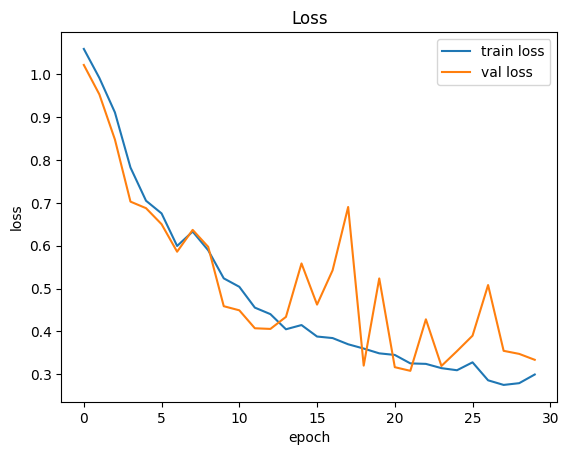

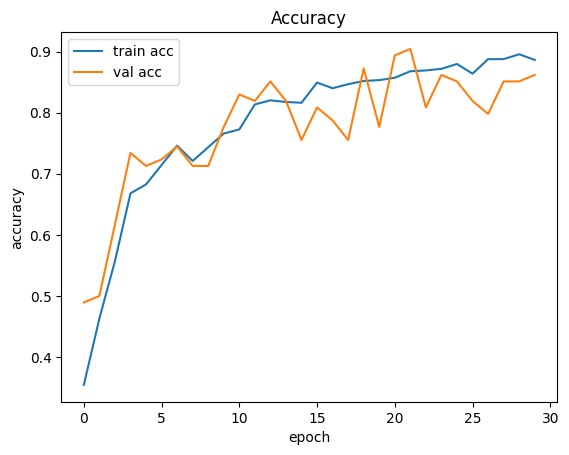

In [8]:
import matplotlib.pyplot as plt

hist = history.history
plt.figure()
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.legend()
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss")
plt.show()

plt.figure()
plt.plot(hist["accuracy"], label="train acc")
plt.plot(hist["val_accuracy"], label="val acc")
plt.legend()
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy")
plt.show()


## Final evaluation: accuracy, classification report, confusion matrix

Here we evaluate on the test set (data never seen during training/validation):

- Print test accuracy.
- Compute predicted classes and show a classification report (per-class precision, recall, F1-score) to see which classes the model handles well.
- Print the confusion matrix to visualize where the model tends to confuse one class with another.

These metrics provide a more complete picture than accuracy alone.

In [9]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

# Predictions & report
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=[id_to_label[i] for i in range(num_classes)]))

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


Test accuracy: 0.853

Classification report:

              precision    recall  f1-score   support

      corona       0.91      0.94      0.92        31
    internal       1.00      0.62      0.77        32
     surface       0.74      1.00      0.85        32

    accuracy                           0.85        95
   macro avg       0.88      0.85      0.85        95
weighted avg       0.88      0.85      0.85        95

Confusion matrix:
 [[29  0  2]
 [ 3 20  9]
 [ 0  0 32]]


## Visualize predictions

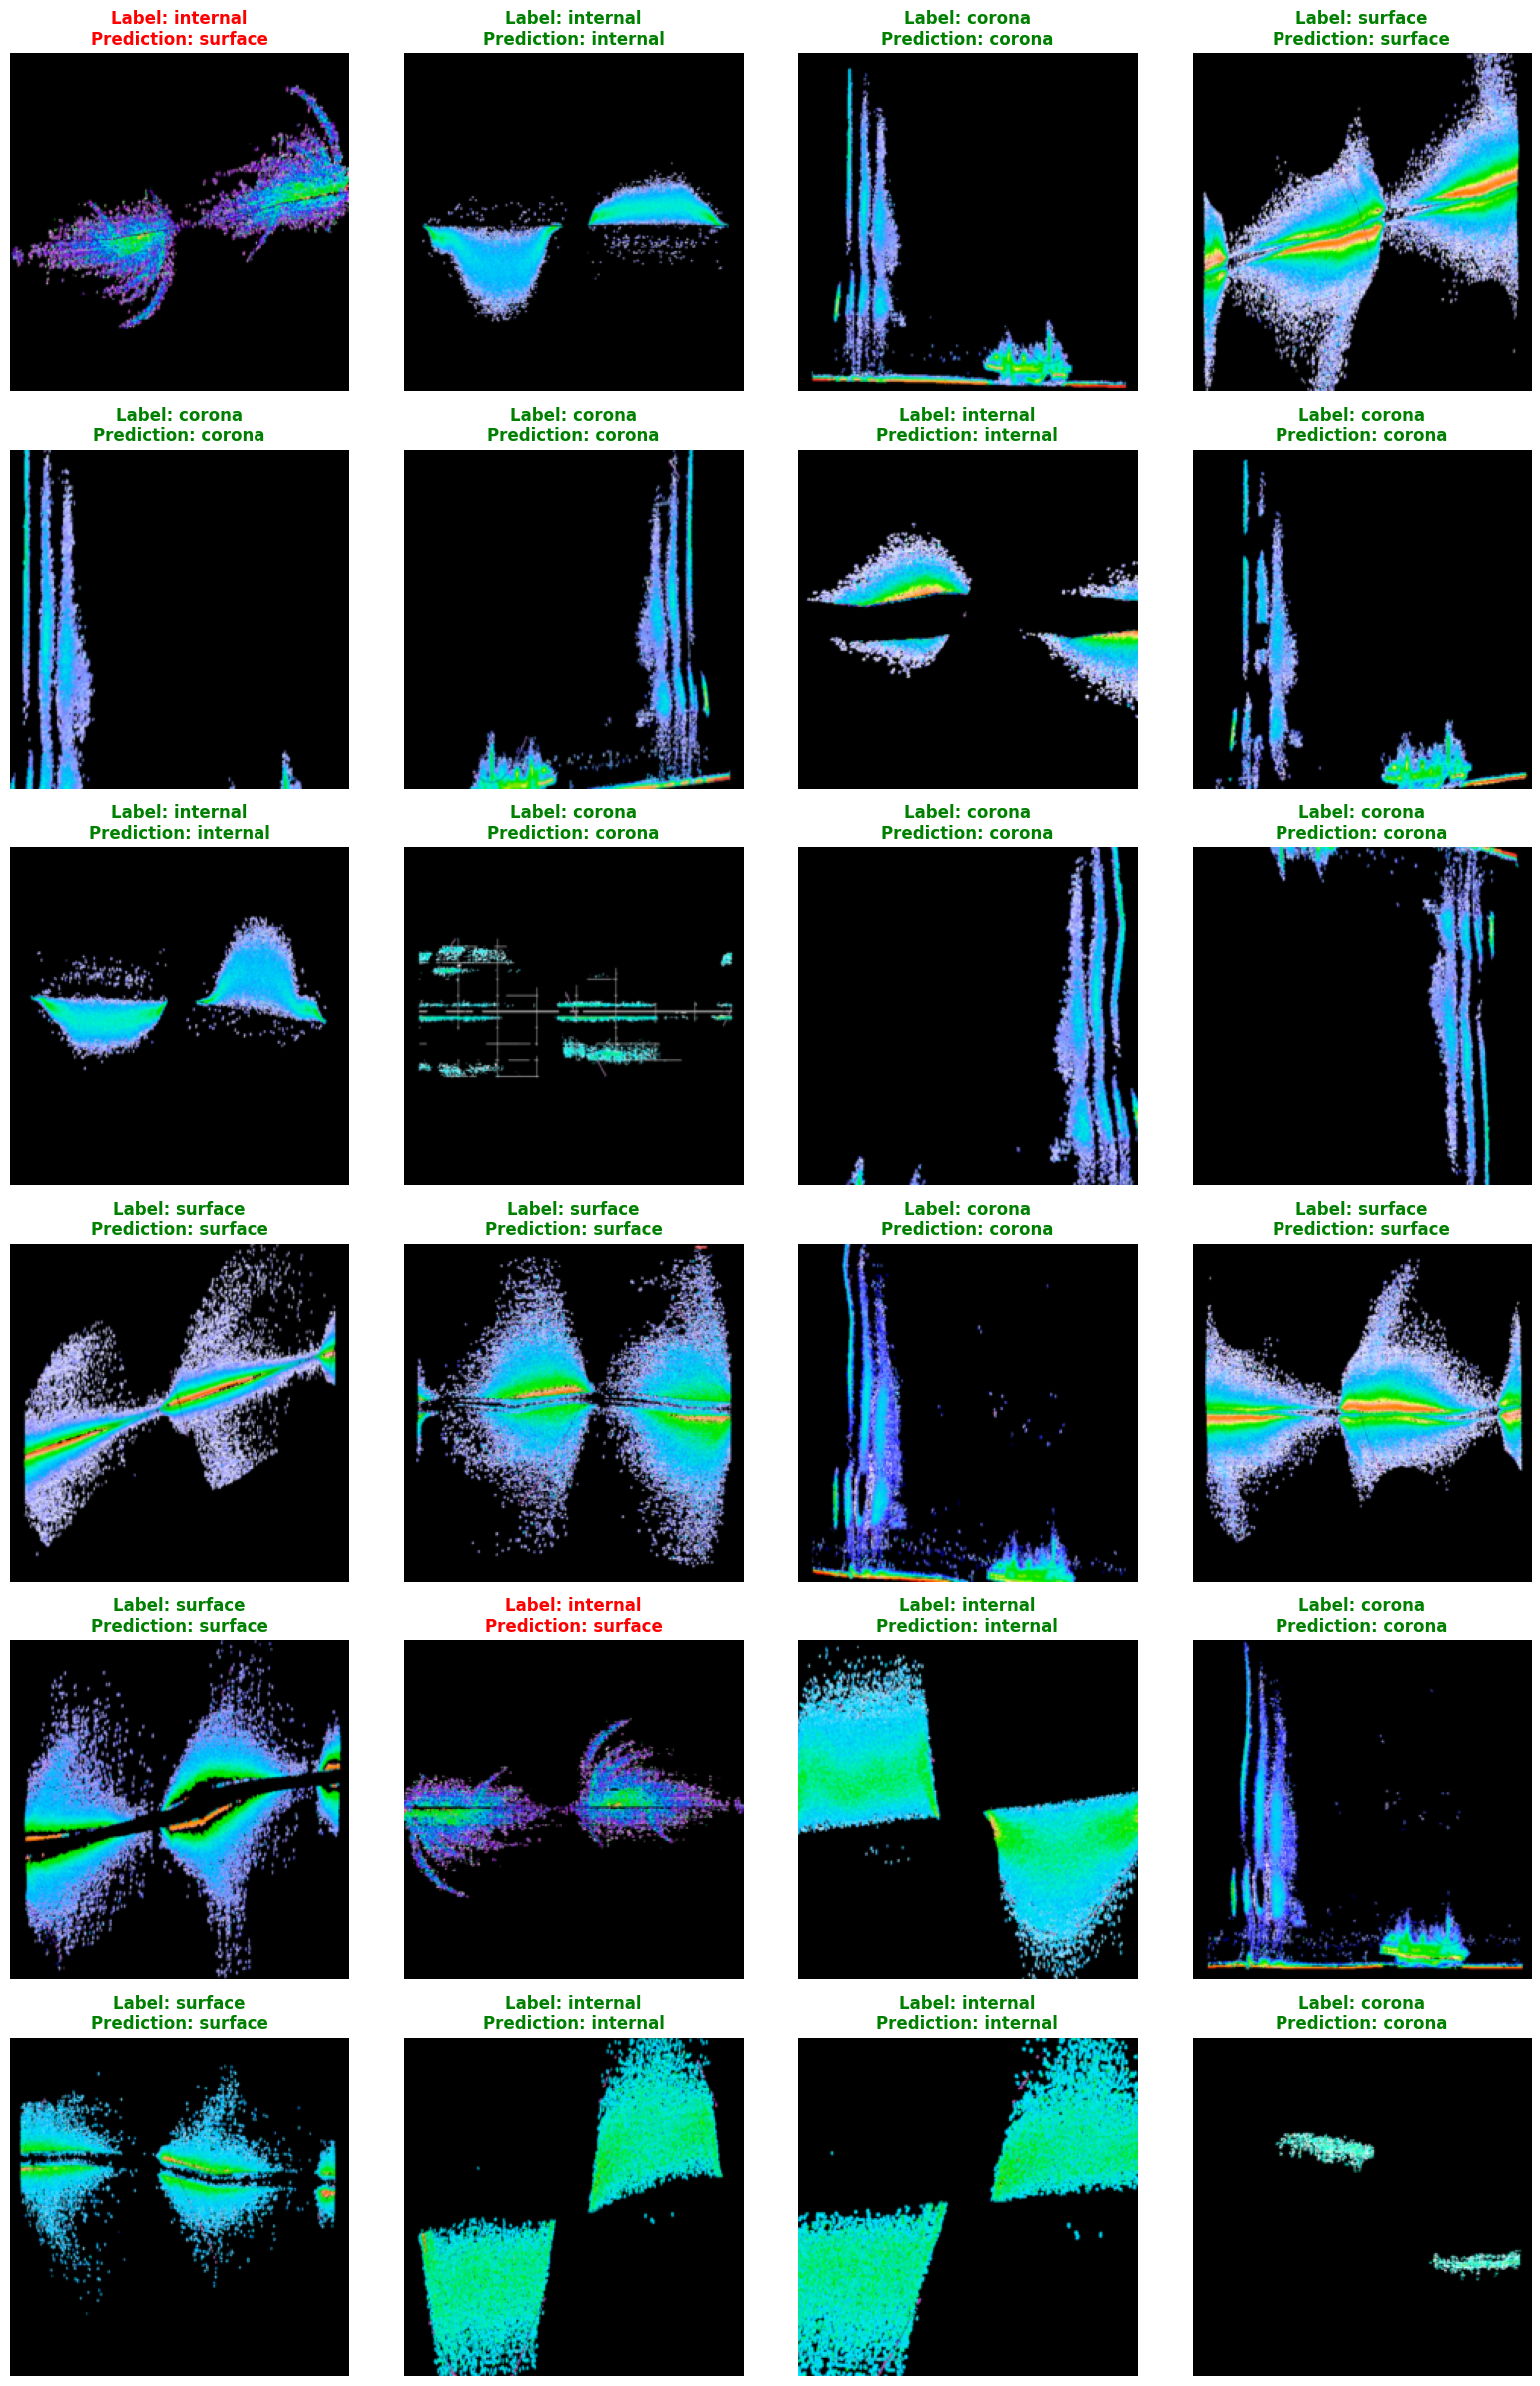

In [10]:
import matplotlib.pyplot as plt
import math

# Grab a reasonable batch from test set for visualization
sample_imgs, sample_lbls = next(iter(test_ds.unbatch().batch(24)))
probs = model.predict(sample_imgs, verbose=0)
pred_ids = probs.argmax(axis=1)
conf = probs.max(axis=1)

n = sample_imgs.shape[0]
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*4, rows*4))
for i in range(n):
    ax = plt.subplot(rows, cols, i+1)
    img = sample_imgs[i].numpy().astype(np.uint8)
    true_id = int(sample_lbls[i].numpy())
    pred_id = int(pred_ids[i])
    p_conf = float(conf[i])

    ax.imshow(img)
    correct = (true_id == pred_id)
    t_label = id_to_label[true_id]
    p_label = id_to_label[pred_id]
    title = f"Label: {t_label}\nPrediction: {p_label}"

    # Title color and a subtle border indicating correctness
    ax.set_title(title, color=("green" if correct else "red"), fontsize=12, weight="bold")
    for spine in ax.spines.values():
        spine.set_edgecolor("green" if correct else "red")
        spine.set_linewidth(2.0)

    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# -----------------------------
# SAVE MODEL
# -----------------------------
# Saves the model in Keras format so it can be reloaded or converted later.

SAVE_PATH = "/content/pd_cnn.keras"
model.save(SAVE_PATH)
print("Saved to:", SAVE_PATH)


Saved to: /content/pd_cnn.keras
